#Import Libaray

In [1]:
from functools import reduce
import numpy as np  # noqa
import pandas as pd  # noqa
from pandas import DataFrame
from freqtrade.persistence import Trade
from typing import Optional
from freqtrade.strategy import (IStrategy)

# --------------------------------
# Add your lib to import here
import talib.abstract as ta
import freqtrade.vendor.qtpylib.indicators as qtpylib
from datetime import datetime, timedelta, timezone
from freqtrade.exchange import timeframe_to_prev_date
from technical.util import resample_to_interval,resampled_merge
import ccxt
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Fetch Crypto

In [2]:
ex = ccxt.binance()

timeframe = "1m"
def ohlcv_info():
    x = ex.fetch_ohlcv('1000BONK/USDT:USDT', timeframe, limit=210)
    df = pd.DataFrame(x, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    df['date'] = pd.to_datetime(df['date'], unit='ms')
    print(f'*** {datetime.now()}  ***\n {df.tail(10)}\n')
    return df

dataframe = ohlcv_info()

*** 2024-04-03 19:25:55.442481  ***
                    date      open      high       low     close     volume
200 2024-04-03 12:46:00  0.022886  0.022891  0.022850  0.022850  1133497.0
201 2024-04-03 12:47:00  0.022851  0.022858  0.022778  0.022801  1746352.0
202 2024-04-03 12:48:00  0.022802  0.022850  0.022777  0.022825  1790652.0
203 2024-04-03 12:49:00  0.022826  0.022846  0.022801  0.022801  1047667.0
204 2024-04-03 12:50:00  0.022801  0.022801  0.022731  0.022766  2867999.0
205 2024-04-03 12:51:00  0.022769  0.022844  0.022769  0.022822  1308546.0
206 2024-04-03 12:52:00  0.022823  0.022860  0.022809  0.022818  3602533.0
207 2024-04-03 12:53:00  0.022817  0.022852  0.022809  0.022850  1240044.0
208 2024-04-03 12:54:00  0.022851  0.022875  0.022823  0.022823  1576226.0
209 2024-04-03 12:55:00  0.022823  0.022837  0.022797  0.022814  1669101.0



#Calculate Other Timeframe for 1min , 5min , 15min

In [3]:
def get_ticker_indicator():
    return int(timeframe[:-1])

def calculateBigTimeTrame(dataframe,minutes):
    big_timeframe = resample_to_interval(dataframe, get_ticker_indicator() * minutes)
    dataframe = resampled_merge(dataframe, big_timeframe)
    return big_timeframe,dataframe

# Calculate 1min to 5min
dataframe_5min,normal_df = calculateBigTimeTrame(dataframe,5)
print(normal_df.columns)

# # Calculate 1minto 15min
# # dataframe_15min = calculateBigTimeTrame(dataframe,15)
# print(dataframe_5min.tail(1))

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'resample_5_date',
       'resample_5_open', 'resample_5_high', 'resample_5_low',
       'resample_5_close', 'resample_5_volume'],
      dtype='object')


#Shift Candle For 1min , 5min, 15min

In [4]:
# For 1 min shift 0-15. At 15 min prediction, 
# for period in range(1,16):
#     dataframe[f"prev_{period}min_open"] = dataframe['open'].shift(period)
#     dataframe[f"prev_{period}min_close"] = dataframe['close'].shift(period)

# # For 5 min shift 3. At 15 min prediction, 0 5 10 minutes will be looked open and close price will be looked
# for period in range(1,4):
#     dataframe_5min[f"prev_{5*period}min_open"] = dataframe_5min['resample_5_open'].shift(period)
#     dataframe_5min[f"prev_{5*period}min_close"] = dataframe_5min['resample_5_close'].shift(period)

#STC Indicator

In [5]:
def convertBigTimeToNormal(data:DataFrame):
    columns = {
        "resample_5_open" : "open",
        "resample_5_high" : "high",
        "resample_5_low" : "low",
        "resample_5_close" : "close",
        "resample_5_volume" : "volume"
    }
    data = data.rename(columns=columns)
    return data

def convertNormalToBigTime(data:DataFrame):
    columns = {
        "open" : "resample_5_open",
        "high" : "resample_5_high",
        "low" : "resample_5_low",
        "close" : "resample_5_close",
        "volume" : "resample_5_volume"
    }
    data = data.rename(columns=columns)
    return data

def calculate_CCI(dataframe,index,diff,ma,p):

    close_array = dataframe['close'].to_numpy()
    close_array = close_array[:index.name]
    diff = diff.to_numpy()
    diff = diff[index.name]
    ma = ma.to_numpy()
    ma = ma[index.name]

    if(len(close_array) < p):
        return 0

    # MAD
    s = 0

    for i in range(len(close_array),len(close_array)-p,-1):
        s = s + abs(dataframe['close'][i] - ma)
    mad = s / p

    # Scalping
    mcci = diff/mad/0.015
    
    return mcci


def minimax(volume,x,p,min,max):
    volume_array = volume.to_numpy()
    volume_array = volume_array[:x.name+1]

    if(len(volume_array) < p):
        return 0

    hi = np.nan_to_num(np.max(volume_array[-p+1:]))
    lo = np.nan_to_num(np.min(volume_array[-p+1:]))

    return (max - min) * (volume_array[len(volume_array)-1] - lo)/(hi - lo) + min

def scale(mom,index,loopback_period):
    mom_array = mom.to_numpy()
    mom_array = mom_array[:index.name+1]

    if(len(mom_array) < loopback_period):
        return 0
    
    current_mom = mom[index.name]
    hi = np.nan_to_num(np.max(mom_array[-loopback_period+1:]))
    lo = np.nan_to_num(np.min(mom_array[-loopback_period+1:]))
    
    return ((current_mom - lo) / (hi - lo)) * 100

def calculate_sm1(s):
    result = []
    for value in s:
        result.append(value if value >= 0 else 0.0)
    return np.sum(result)

def calculate_sm2(s):
    result = []
    for value in s:
        result.append(0.0 if value >= 0 else -value)
    return np.sum(result)

def calculate_mfi_upper(s,x):
    result = np.where(s >= 0, 0.0, x)
    return np.sum(result)

def calculate_mfi_lower(s,x):
    result = np.where(s <= 0, 0.0, x)
    return np.sum(result)

def pine_cmo(src:pd.Series, length):
    # Calculate the momentum (change) of the source data
    mom = src - src.shift(1)
    
    # Calculate the sum of positive and negative momentum over the specified length
    sm1 = mom.rolling(length).apply(calculate_sm1,raw=True)
    sm2 = mom.rolling(length).apply(calculate_sm2,raw=True)
    
    # Calculate the Chande Momentum Oscillator (CMO)
    cmo = 100 * ((sm1 - sm2) / (sm1 + sm2))
    
    return cmo

#Populate Indicator

In [6]:
LongWindow = 15
MediumWindow = 5
ShortWindow = 2


dataframe_copy = dataframe
# Input Source
source = dataframe_copy['close']

# DIFF
dataframe_copy['mas'] = ta.SMA(source,timeperiod=LongWindow)
dataframe_copy['diffs'] = source - dataframe_copy['mas']

dataframe_copy['maf'] = ta.SMA(source,timeperiod=ShortWindow)
dataframe_copy['difff'] = source - dataframe_copy['maf']

# ============ Long Window ============
dataframe_copy['rs'] = ta.RSI(source,timeperiod=LongWindow)
dataframe_copy['cs'] = dataframe_copy.apply((lambda index: calculate_CCI(dataframe_copy,index,dataframe_copy['diffs'],dataframe_copy['mas'],LongWindow)),axis=1)
dataframe_copy['os'] = ta.ROC(source,timeperiod=LongWindow)
dataframe_copy['vs'] = dataframe_copy.apply((lambda x: minimax(dataframe_copy['volume'],x,LongWindow,0,99)),axis=1)
dataframe_copy['cmos'] = pine_cmo(source,LongWindow)
dataframe_copy['emas'] = ta.EMA(dataframe_copy,timeperiod=LongWindow)

# ============ Medium Window ============
dataframe_copy['rm'] = ta.RSI(source,timeperiod=MediumWindow)
dataframe_copy['cm'] = dataframe_copy.apply((lambda index: calculate_CCI(dataframe_copy,index,dataframe_copy['diffs'],dataframe_copy['mas'],MediumWindow)),axis=1)
dataframe_copy['om'] = ta.ROC(source,timeperiod=MediumWindow)
dataframe_copy['vm'] = dataframe_copy.apply((lambda x: minimax(dataframe_copy['volume'],x,MediumWindow,0,99)),axis=1)
dataframe_copy['cmom'] = pine_cmo(source,MediumWindow)
dataframe_copy['emam'] = ta.EMA(dataframe_copy,timeperiod=MediumWindow)

# =========== Short window =============
dataframe_copy['rf'] = ta.RSI(source,timeperiod=ShortWindow)
dataframe_copy['cf'] = dataframe_copy.apply((lambda index: calculate_CCI(dataframe_copy,index,dataframe_copy['difff'],dataframe_copy['maf'],ShortWindow)),axis=1)
dataframe_copy['of'] = ta.ROC(source,timeperiod=ShortWindow)
dataframe_copy['vf'] = dataframe_copy.apply((lambda x: minimax(dataframe_copy['volume'],x,ShortWindow,0,99)),axis=1)
dataframe_copy['cmof'] = pine_cmo(source,ShortWindow)
dataframe_copy['emaf'] = ta.EMA(dataframe_copy,timeperiod=ShortWindow)

dataframe_copy['f1'] = dataframe_copy.loc[:,['os','emas','cmos','rs','maf']].mean(axis=1)
dataframe_copy['f2'] = dataframe_copy.loc[:,['om','emam','cmom','rm','cm','vm']].mean(axis=1)
dataframe_copy['f3'] = dataframe_copy.loc[:,['of','emaf','cmof','rf','cf','vf']].mean(axis=1)
dataframe_copy['output'] = dataframe_copy["close"].shift(-1) - dataframe_copy["close"]

Normalize and Visualize Data

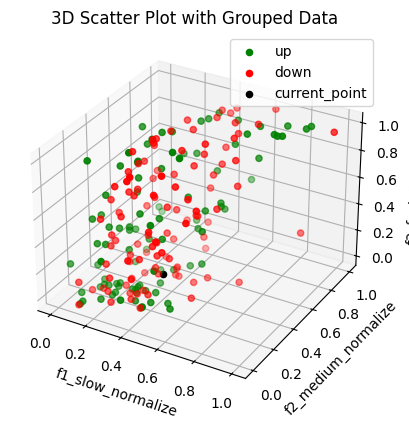

In [7]:
min_max_scaler = preprocessing.MinMaxScaler()
dataframe_copy[['f1_slow_normalize','f2_medium_normalize','f3_fast_normalize']] = min_max_scaler.fit_transform(dataframe_copy[['f1','f2','f3']])
new_f1 = dataframe_copy.tail(1)['f1_slow_normalize'].values
new_f2 = dataframe_copy.tail(1)['f2_medium_normalize'].values
new_f3 = dataframe_copy.tail(1)['f3_fast_normalize'].values

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
up_points = dataframe_copy[dataframe_copy['output'] > 0]
ax.scatter(up_points['f1_slow_normalize'], up_points['f2_medium_normalize'],up_points['f3_fast_normalize'], c='green', label='up')
down_points = dataframe_copy[dataframe_copy['output'] < 0]
ax.scatter(down_points['f1_slow_normalize'], down_points['f2_medium_normalize'],down_points['f3_fast_normalize'], c='red', label='down')
ax.scatter(new_f1, new_f2, new_f3, c='black', label='current_point')
ax.set_xlabel('f1_slow_normalize')
ax.set_ylabel('f2_medium_normalize')
ax.set_zlabel('f3_fast_normalize')
ax.set_title('3D Scatter Plot with Grouped Data')
ax.legend()
plt.show()

#Machine Learning Euclidean Distance Similiarity

In [8]:
# Step 1: Data Preparation
features = dataframe_copy[['f1_slow_normalize','f2_medium_normalize','f3_fast_normalize']]
output = dataframe_copy[['output']]

data_combined = pd.concat([features, output], axis=1)
data_for_prediction = pd.concat([dataframe], axis=1)
data_for_prediction.fillna(0,inplace=True)
data_combined.dropna(inplace=True)
X = data_combined.loc[:,['f1_slow_normalize','f2_medium_normalize','f3_fast_normalize']]
y = np.where(data_combined['output'] > 0,1,-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=37)

# Step 2: Model Selection
knn_model = KNeighborsClassifier(n_neighbors=1)
gnb_model = GaussianNB()
random_forest_model = RandomForestClassifier(n_estimators=15, random_state=37)

model = VotingClassifier(
                        estimators=[
                            ('knn', knn_model),
                            ('rf', random_forest_model),
                            ('gnb', gnb_model)
                        ], 
                        voting='soft',
                        )

# Step 3: Model Training
model.fit(X_train, y_train)

# Step 4: Model Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Step 5: Prediction
# Assuming X_new is your new data for prediction
# data_for_prediction['last_10_predicted_value'] = model.predict(data_for_prediction[['f1_slow_normalize','f2_medium_normalize','f3_fast_normalize']])
# candle_to_predict = data_for_prediction.loc[len(data_for_prediction)-10:len(data_for_prediction)-8, 'last_10_predicted_value']
# total_prediction = candle_to_predict.sum()
# data_for_prediction['predicted_value'] = data_for_prediction['last_10_predicted_value'] + data_for_prediction['last_10_predicted_value'].shift(-1) + data_for_prediction['last_10_predicted_value'].shift(-2)
# data_for_prediction['predicted_value'] = data_for_prediction['predicted_value'].shift(10)
# print(data_for_prediction.loc[480:490,['date','output','last_10_predicted_value','close']])

data_for_prediction['prediction_value_y'] = model.predict(data_for_prediction[['f1_slow_normalize','f2_medium_normalize','f3_fast_normalize']])
data_for_prediction['output'] = np.where(data_for_prediction['output'] > 0,1,-1)
accuracy = accuracy_score(data_for_prediction['prediction_value_y'], data_for_prediction['output'])
print("Accuracy:", accuracy)
data_for_prediction['prediction_value_y'] = data_for_prediction['prediction_value_y']
print(data_for_prediction.loc[len(data_for_prediction)-20:,['f1_slow_normalize','prediction_value_y','output','close']])

Accuracy: 0.7142857142857143
Accuracy: 0.9619047619047619
     f1_slow_normalize  prediction_value_y  output     close
190           0.073917                   1       1  0.022798
191           0.083317                   1       1  0.022806
192           0.288323                  -1      -1  0.022882
193           0.304880                  -1      -1  0.022875
194           0.214453                  -1      -1  0.022857
195           0.191339                   1       1  0.022797
196           0.333748                  -1      -1  0.022858
197           0.280388                   1       1  0.022849
198           0.305647                   1       1  0.022865
199           0.376909                  -1      -1  0.022884
200           0.352153                  -1      -1  0.022850
201           0.282977                   1       1  0.022801
202           0.384312                  -1      -1  0.022825
203           0.340878                  -1      -1  0.022801
204           0.316793     